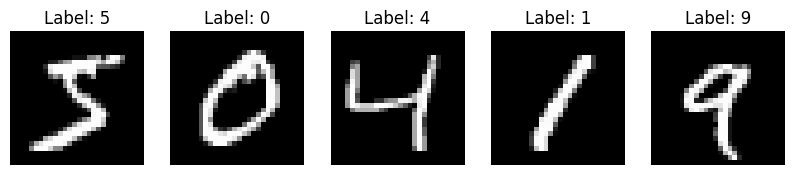

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Load MNIST
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# Plot 5 example digits
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = mnist[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()



In [ ]:
# Variational Autoencoder on MNIST with PyTorch in Google Colab

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 28*28)

    def encode(self, x):
        x = x.view(-1, 28*28)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        out = torch.sigmoid(self.fc5(h4))
        return out.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        out = self.decode(z)
        return out, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between N(mu, var) and N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()/len(data):.4f}")
    print(f"====> Epoch: {epoch} Average loss: {train_loss/len(train_loader.dataset):.4f}")

def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")

# Train for 10 epochs
for epoch in range(1, 11):
    train(epoch)
    test()


Using device: cpu
Train Epoch: 1 [0/60000] Loss: 544.1819
Train Epoch: 1 [12800/60000] Loss: 183.3118
Train Epoch: 1 [25600/60000] Loss: 174.9043
Train Epoch: 1 [38400/60000] Loss: 166.1085
Train Epoch: 1 [51200/60000] Loss: 162.4548
====> Epoch: 1 Average loss: 181.2278
====> Test set loss: 162.3402
Train Epoch: 2 [0/60000] Loss: 160.8825
Train Epoch: 2 [12800/60000] Loss: 164.0723
Train Epoch: 2 [25600/60000] Loss: 154.2958
Train Epoch: 2 [38400/60000] Loss: 162.0958
Train Epoch: 2 [51200/60000] Loss: 159.3882
====> Epoch: 2 Average loss: 158.2888
====> Test set loss: 155.1153
Train Epoch: 3 [0/60000] Loss: 155.4967
Train Epoch: 3 [12800/60000] Loss: 142.8589
Train Epoch: 3 [25600/60000] Loss: 153.4662
Train Epoch: 3 [38400/60000] Loss: 146.9732
Train Epoch: 3 [51200/60000] Loss: 147.3407
====> Epoch: 3 Average loss: 153.7902
====> Test set loss: 152.2640
Train Epoch: 4 [0/60000] Loss: 155.2201
Train Epoch: 4 [12800/60000] Loss: 150.3217
Train Epoch: 4 [25600/60000] Loss: 162.3705
Tr

In [ ]:
from scipy.interpolate import splprep, splev

# Get x and y coordinates
x, y = latent_vectors[:, 0], latent_vectors[:, 1]

# Fit a spline through the 5 points (parametric curve)
tck, u = splprep([x, y], s=0)  # s=0 => interpolate through points

# Evaluate spline and its first and second derivatives
u_fine = np.linspace(0, 1, 100)
x_spline, y_spline = splev(u_fine, tck)
dx, dy = splev(u_fine, tck, der=1)
ddx, ddy = splev(u_fine, tck, der=2)

# Compute 2D curvature: κ = |x'y'' - y'x''| / (x'^2 + y'^2)^(3/2)
curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5

# Plot curve and curvature color
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_spline, y_spline, c=curvature, cmap='viridis', s=20)
plt.colorbar(sc, label='Curvature κ')
plt.plot(x, y, 'ro', label='Original Points')
plt.title("Latent Curve and Curvature")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


NameError: name 'latent_vectors' is not defined

In [ ]:
import torch
import numpy as np

# Make sure model is in eval mode and using correct device
model.eval()
device = next(model.parameters()).device

# Load MNIST again (if needed)
from torchvision import datasets, transforms
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Extract 5 example images and pass through encoder
latent_vectors = []
labels = []

for i in range(5):
    img, label = mnist[i]
    labels.append(label)
    img = img.unsqueeze(0).to(device)  # shape: (1, 1, 28, 28)

    with torch.no_grad():
        mu, logvar = model.encode(img)
        latent_vectors.append(mu.squeeze().cpu().numpy())

latent_vectors = np.stack(latent_vectors)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


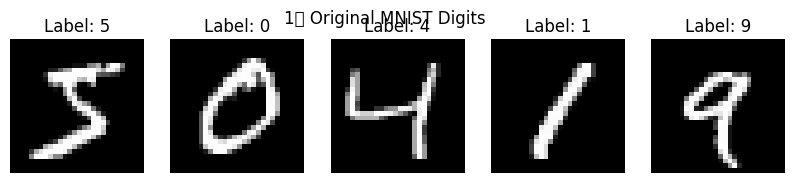

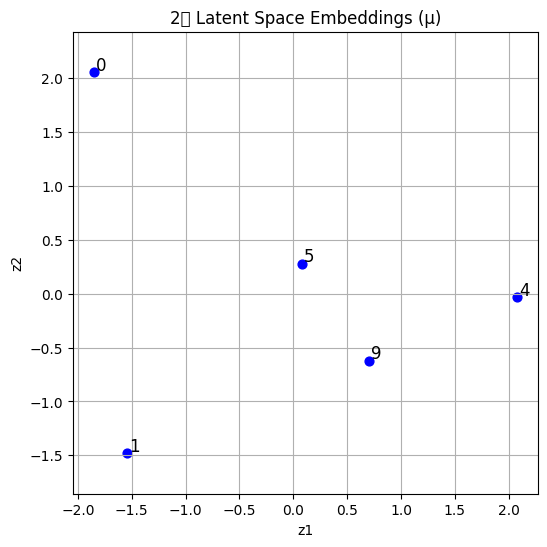

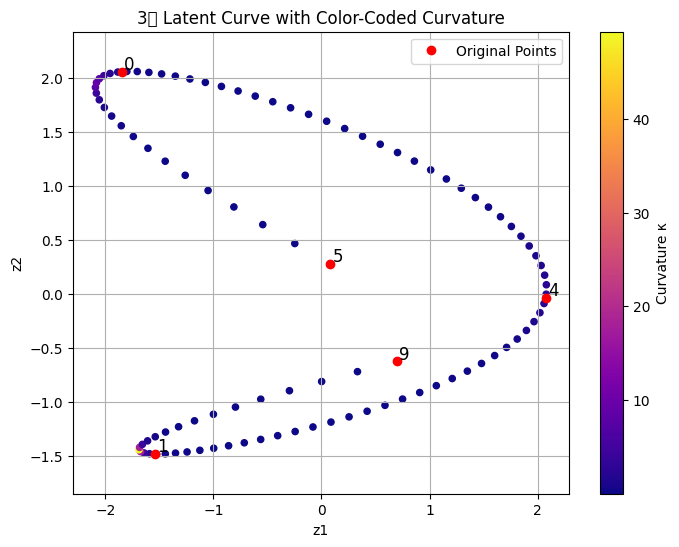

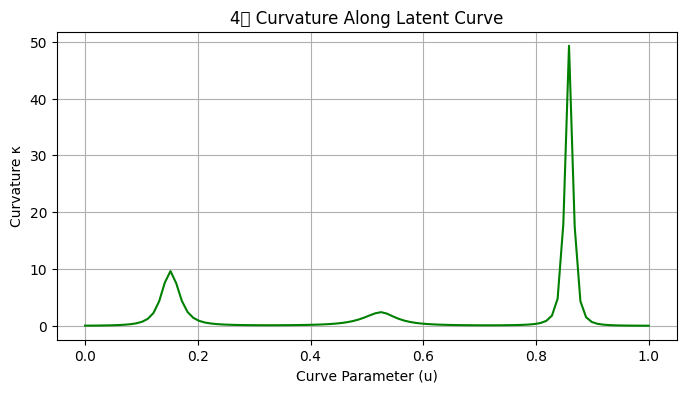

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.interpolate import splprep, splev

# Ensure model is in eval mode
model.eval()
device = next(model.parameters()).device

# Load MNIST and select first 5 images
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
imgs, labels, latent_vectors = [], [], []

for i in range(5):
    img, label = mnist[i]
    imgs.append(img.squeeze().numpy())
    labels.append(label)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        mu, logvar = model.encode(img)
        latent_vectors.append(mu.squeeze().cpu().numpy())

latent_vectors = np.stack(latent_vectors)
x, y = latent_vectors[:, 0], latent_vectors[:, 1]

# --------------------------
# Plot 1: Raw MNIST digits
# --------------------------
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(imgs[i], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')
plt.suptitle("1️⃣ Original MNIST Digits")
plt.show()

# --------------------------
# Plot 2: Latent points
# --------------------------
plt.figure(figsize=(6, 6))
plt.scatter(x, y, c='blue', s=40)
for i, label in enumerate(labels):
    plt.text(x[i] + 0.02, y[i] + 0.02, str(label), fontsize=12)
plt.title("2️⃣ Latent Space Embeddings (μ)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.axis("equal")
plt.show()

# --------------------------
# Plot 3–4: Latent Curve + Curvature
# --------------------------
# Fit spline
tck, u = splprep([x, y], s=0)
u_fine = np.linspace(0, 1, 100)
x_spline, y_spline = splev(u_fine, tck)
dx, dy = splev(u_fine, tck, der=1)
ddx, ddy = splev(u_fine, tck, der=2)

# Curvature formula
curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5

# Plot curve and curvature
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_spline, y_spline, c=curvature, cmap='plasma', s=20)
plt.colorbar(sc, label='Curvature κ')
plt.plot(x, y, 'ro', label='Original Points')
for i, label in enumerate(labels):
    plt.text(x[i]+0.02, y[i]+0.02, str(label), fontsize=12)
plt.title("3️⃣ Latent Curve with Color-Coded Curvature")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

# --------------------------
# Plot 5: Curvature vs Curve Parameter (u)
# --------------------------
plt.figure(figsize=(8, 4))
plt.plot(u_fine, curvature, color='green')
plt.title("4️⃣ Curvature Along Latent Curve")
plt.xlabel("Curve Parameter (u)")
plt.ylabel("Curvature κ")
plt.grid(True)
plt.show()


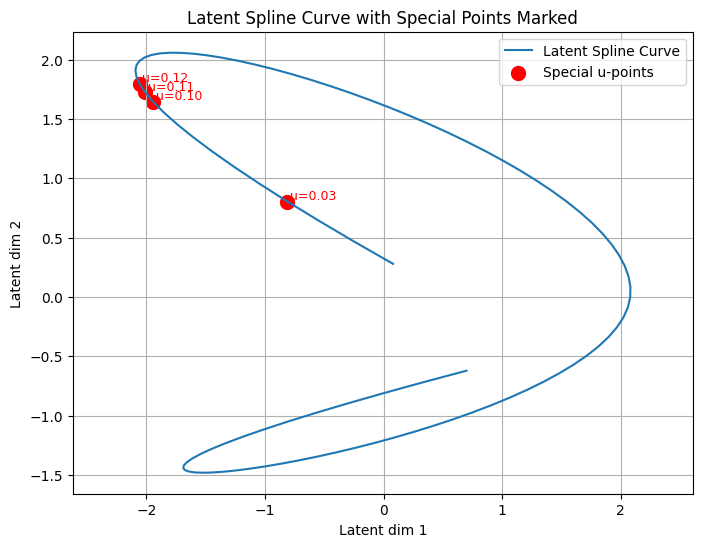

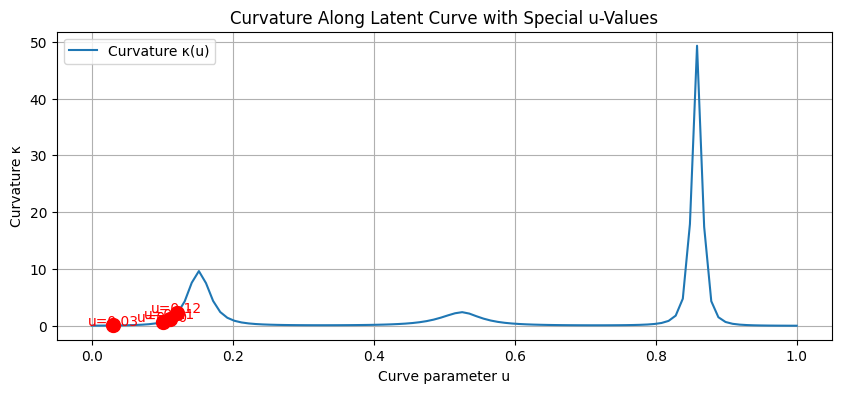

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you already have:
# - tck: the B-spline representing the latent curve
# - u_fine: the parameter values from 0 to 1 (e.g., np.linspace(0, 1, 100))
# - curvature: the curvature array corresponding to u_fine
# - x_spline, y_spline = splev(u_fine, tck)

# Your special u-values
special_us = [0.03, 0.1, 0.11, 0.12]

# Find closest indices in u_fine
special_indices = [np.argmin(np.abs(u_fine - u)) for u in special_us]
special_curvatures = [curvature[i] for i in special_indices]
special_xs = [x_spline[i] for i in special_indices]
special_ys = [y_spline[i] for i in special_indices]

# --- Plot 1: Spline Curve with Special Points ---
plt.figure(figsize=(8, 6))
plt.plot(x_spline, y_spline, label='Latent Spline Curve')
plt.scatter(special_xs, special_ys, color='red', s=100, label='Special u-points')
for i, u in enumerate(special_us):
    plt.text(special_xs[i]+0.02, special_ys[i]+0.02, f"u={u:.2f}", fontsize=9, color='red')
plt.title("Latent Spline Curve with Special Points Marked")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# --- Plot 2: Curvature vs u with Special u-values ---
plt.figure(figsize=(10, 4))
plt.plot(u_fine, curvature, label='Curvature κ(u)')
plt.scatter(special_us, special_curvatures, color='red', s=100, zorder=5)
for i, u in enumerate(special_us):
    plt.text(u, special_curvatures[i] + 0.1, f"u={u:.2f}", ha='center', color='red')
plt.title("Curvature Along Latent Curve with Special u-Values")
plt.xlabel("Curve parameter u")
plt.ylabel("Curvature κ")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'these are where hte points 3 and 6 were discovered in latent space'

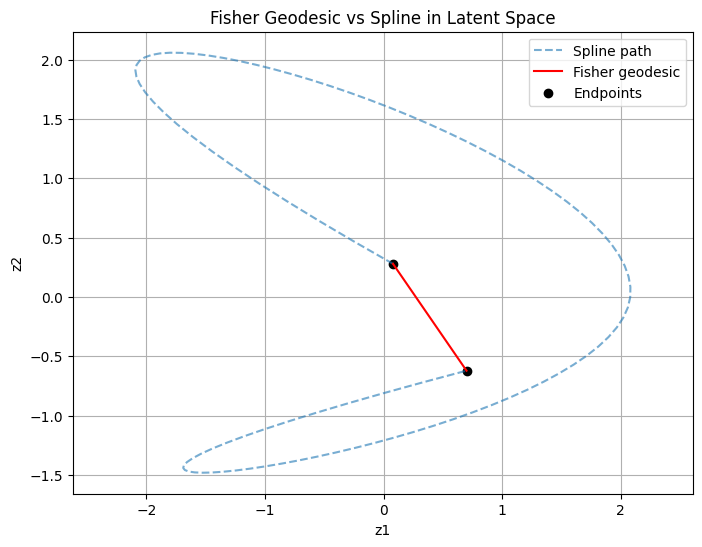

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv, fractional_matrix_power

def fisher_geodesic_cov(S1, S2, t):
    sqrt_S1 = sqrtm(S1)
    inv_sqrt_S1 = inv(sqrt_S1)
    middle = inv_sqrt_S1 @ S2 @ inv_sqrt_S1
    middle_t = fractional_matrix_power(middle, t)
    return sqrt_S1 @ middle_t @ sqrt_S1

def fisher_geodesic_mean(mu1, mu2, t):
    return (1 - t) * mu1 + t * mu2

# EXAMPLE: pick 2 points on spline (u = 0.0 and u = 1.0)
mu1 = np.array(splev(0.0, tck))  # shape (2,)
mu2 = np.array(splev(1.0, tck))  # shape (2,)

# Dummy covariance (identity) for illustration
# Replace with your actual encoded variances if you have them
S1 = np.eye(2)  # e.g., encoder logvar[0] -> exp -> diag
S2 = np.eye(2) * 0.5

# Interpolate along geodesic
ts = np.linspace(0, 1, 100)
mu_path = np.array([fisher_geodesic_mean(mu1, mu2, t) for t in ts])
cov_path = np.array([fisher_geodesic_cov(S1, S2, t) for t in ts])

# Plot spline and Fisher geodesic
plt.figure(figsize=(8, 6))
plt.plot(x_spline, y_spline, label='Spline path', linestyle='--', alpha=0.6)
plt.plot(mu_path[:, 0], mu_path[:, 1], color='red', label='Fisher geodesic')
plt.scatter([mu1[0], mu2[0]], [mu1[1], mu2[1]], color='black', label='Endpoints')
plt.legend()
plt.title("Fisher Geodesic vs Spline in Latent Space")
plt.xlabel("z1")
plt.ylabel("z2")
plt.axis('equal')
plt.grid(True)
plt.show()


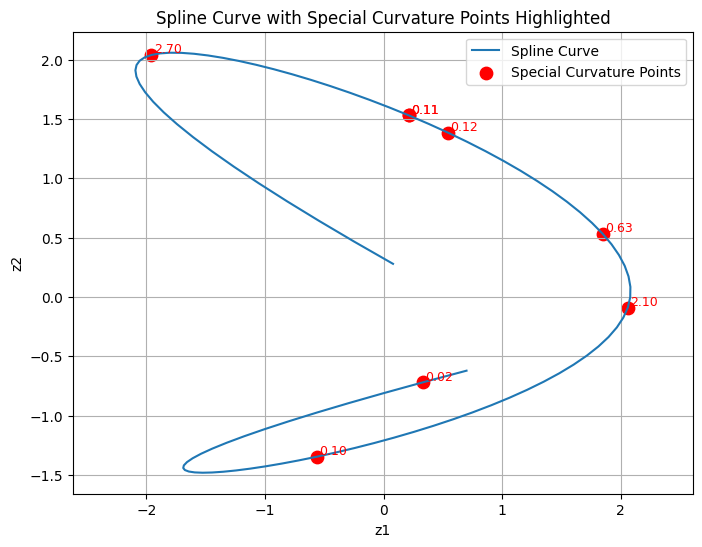

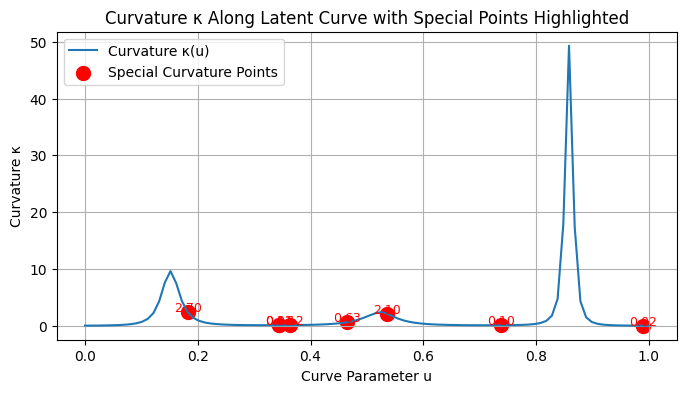

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your special curvature values
special_k = np.array([0.02, 0.1, 0.11, 0.12, 0.63, 2.1, 2.7, 0.11])

# Function to find the closest index in curvature array to each special k
def find_closest_indices(k_values, curvature_array):
    indices = []
    for k in k_values:
        idx = np.argmin(np.abs(curvature_array - k))
        indices.append(idx)
    return indices

special_indices = find_closest_indices(special_k, curvature)

# Get corresponding u parameters for these indices
u_special = u_fine[special_indices]

# Get corresponding spline points
x_special = x_spline[special_indices]
y_special = y_spline[special_indices]

# ---- Plot 1: Spline curve with highlighted special curvature points ----
plt.figure(figsize=(8, 6))
plt.plot(x_spline, y_spline, label='Spline Curve')
plt.scatter(x_special, y_special, c='red', s=80, marker='o', label='Special Curvature Points')
for i, k_val in enumerate(special_k):
    plt.text(x_special[i] + 0.02, y_special[i] + 0.02, f"{k_val:.2f}", color='red', fontsize=9)
plt.title("Spline Curve with Special Curvature Points Highlighted")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# ---- Plot 2: Curvature vs latent curve parameter with highlights ----
plt.figure(figsize=(8, 4))
plt.plot(u_fine, curvature, label='Curvature κ(u)')
plt.scatter(u_special, curvature[special_indices], c='red', s=100, marker='o', label='Special Curvature Points')
for i, k_val in enumerate(special_k):
    plt.text(u_special[i], curvature[special_indices][i] + 0.1, f"{k_val:.2f}", color='red', fontsize=9, ha='center')
plt.title("Curvature κ Along Latent Curve with Special Points Highlighted")
plt.xlabel("Curve Parameter u")
plt.ylabel("Curvature κ")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# x =paramer u rning along spline, normalized 0 to 1, y= curvature, how sharply the latent trajectory bends, SELECT POINTS'

SyntaxError: invalid syntax (ipython-input-12-256581446.py, line 1)

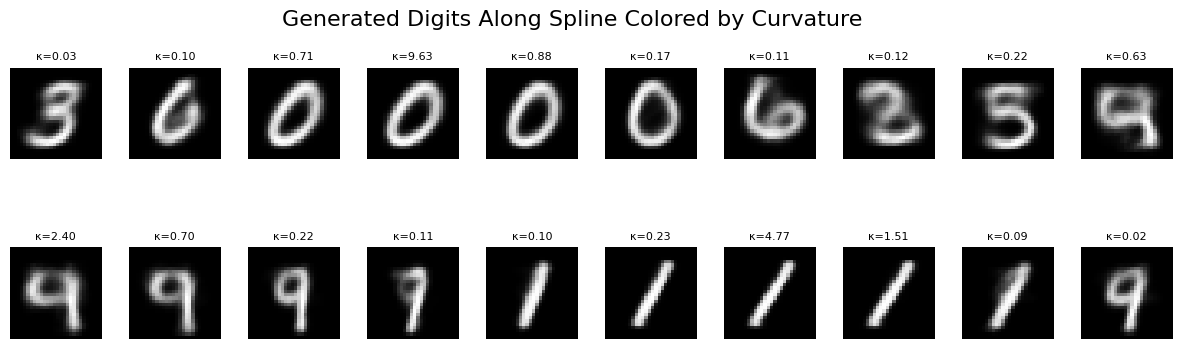

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Parameters
num_samples = 20  # how many points along spline to generate
u_vals = np.linspace(0, 1, num_samples)

# Prepare figure with gridspec for nice layout
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(2, num_samples // 2, hspace=0.4, wspace=0.3)

# Normalize curvature colors for colormap
curv_norm = (curvature - curvature.min()) / (curvature.max() - curvature.min())

for i, u in enumerate(u_vals):
    # Get latent point
    z = np.array(splev(u, tck))
    z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)

    # Decode digit
    model.eval()
    with torch.no_grad():
        img = model.decode(z_tensor).cpu().squeeze().numpy()

    # Map u to closest curvature index (since curvature is 100 points)
    idx = int(u * (len(curvature) - 1))
    color_val = curv_norm[idx]

    # Plot image in grid cell
    ax = fig.add_subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f"κ={curvature[idx]:.2f}", fontsize=8)
    # Add colored border reflecting curvature value
    for spine in ax.spines.values():
        spine.set_edgecolor(plt.cm.plasma(color_val))
        spine.set_linewidth(3)

plt.suptitle("Generated Digits Along Spline Colored by Curvature", fontsize=16)
plt.show()


In [ ]:
'discovered 3 and 6 and almost 4 and even weaker 7, but the 3 can be ambiguously 8 even  wow'

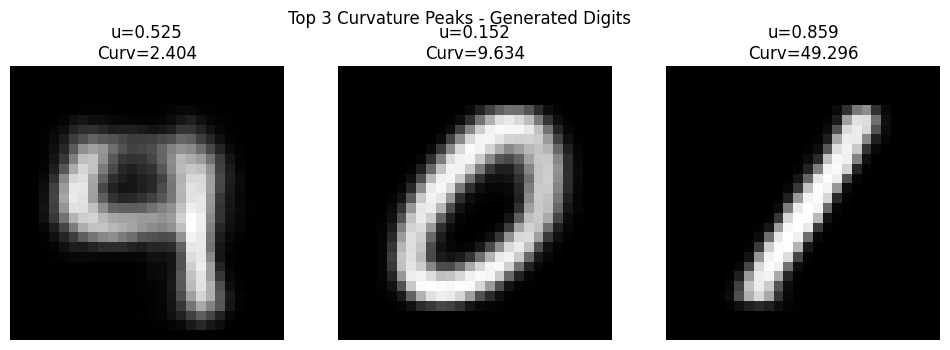

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.signal import find_peaks

# Assuming you have:
# curvature : numpy array of curvature values along u_fine
# u_fine : numpy array of latent curve parameters corresponding to curvature
# splev and tck for spline evaluation
# trained VAE model as `model` on device `device`

# Step 1: Detect curvature peaks (local maxima)
peaks_indices, _ = find_peaks(curvature, height=0)  # height=0 filters very small peaks, adjust if needed

# Optional: filter to top N peaks by curvature value, e.g., top 3
num_peaks = 3
top_peaks_idx = peaks_indices[np.argsort(curvature[peaks_indices])][-num_peaks:]

# Step 2: Plot predicted digits at these peaks
fig, axes = plt.subplots(1, num_peaks, figsize=(num_peaks * 4, 4))

model.eval()
with torch.no_grad():
    for i, idx in enumerate(top_peaks_idx):
        u = u_fine[idx]
        k_val = curvature[idx]

        # Get latent vector at peak
        z = np.array(splev(u, tck))
        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)

        # Decode latent vector to image
        decoded_img = model.decode(z_tensor).cpu().squeeze().numpy()

        # Plot digit
        axes[i].imshow(decoded_img, cmap='gray')
        axes[i].set_title(f"u={u:.3f}\nCurv={k_val:.3f}")
        axes[i].axis('off')

plt.suptitle(f"Top {num_peaks} Curvature Peaks - Generated Digits")
plt.show()


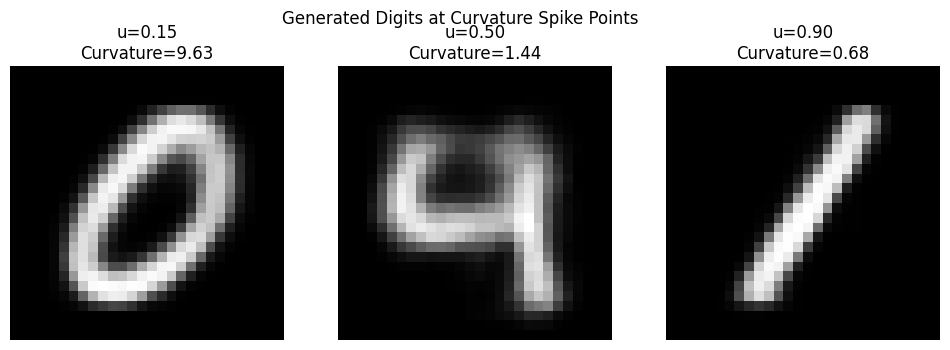

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Spike locations on latent curve parameter u
spike_us = [0.15, 0.5, 0.9]

fig, axes = plt.subplots(1, len(spike_us), figsize=(12, 4))

model.eval()
with torch.no_grad():
    for i, u in enumerate(spike_us):
        # Get latent vector at spike parameter u
        z = np.array(splev(u, tck))  # shape (2,)
        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)

        # Decode to generate digit
        decoded_img = model.decode(z_tensor).cpu().squeeze().numpy()

        # Find curvature closest to u
        idx = np.argmin(np.abs(u_fine - u))
        curv_val = curvature[idx]

        # Plot the decoded image
        axes[i].imshow(decoded_img, cmap='gray')
        axes[i].set_title(f"u={u:.2f}\nCurvature={curv_val:.2f}")
        axes[i].axis('off')

plt.suptitle("Generated Digits at Curvature Spike Points")
plt.show()


In [ ]:
'curvature is telling us model representation is changing at these points'

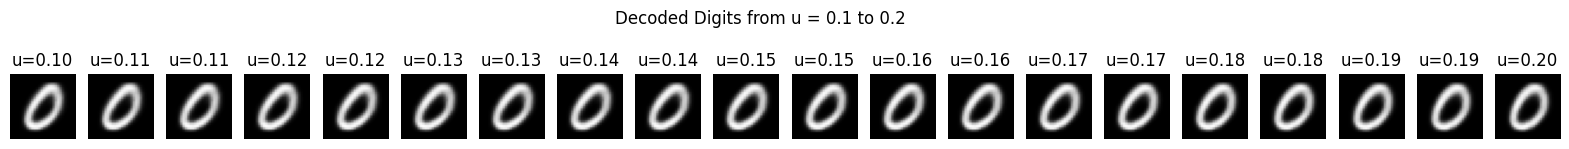

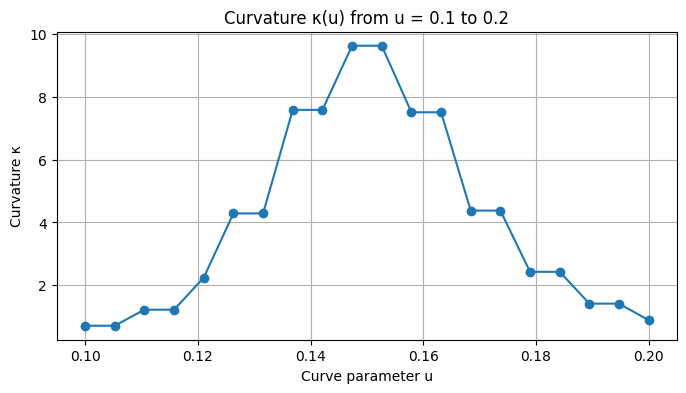

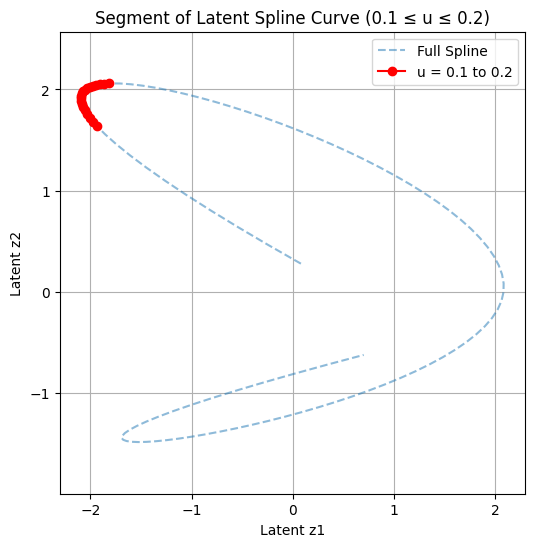

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import splev

# Sample 20 u values between 0.1 and 0.2
u_samples = np.linspace(0.1, 0.2, 20)

# Prepare storage
decoded_imgs = []
curvatures_subset = []
latent_coords = []

model.eval()
with torch.no_grad():
    for u in u_samples:
        # Latent vector from spline
        z = np.array(splev(u, tck))  # shape (2,)
        latent_coords.append(z)

        # Decode
        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)
        decoded = model.decode(z_tensor).cpu().squeeze().numpy()
        decoded_imgs.append(decoded)

        # Curvature at closest point
        idx = np.argmin(np.abs(u_fine - u))
        curvatures_subset.append(curvature[idx])

latent_coords = np.array(latent_coords)
curvatures_subset = np.array(curvatures_subset)

# -----------------------------
# Plot 1: Predicted digits
plt.figure(figsize=(20, 2))
for i, img in enumerate(decoded_imgs):
    plt.subplot(1, len(decoded_imgs), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"u={u_samples[i]:.2f}")
    plt.axis('off')
plt.suptitle("Decoded Digits from u = 0.1 to 0.2")
plt.show()

# -----------------------------
# Plot 2: Curvature along these points
plt.figure(figsize=(8, 4))
plt.plot(u_samples, curvatures_subset, marker='o')
plt.title("Curvature κ(u) from u = 0.1 to 0.2")
plt.xlabel("Curve parameter u")
plt.ylabel("Curvature κ")
plt.grid(True)
plt.show()

# -----------------------------
# Plot 3: Position on the latent curve
plt.figure(figsize=(6, 6))
plt.plot(x_spline, y_spline, linestyle='--', alpha=0.5, label="Full Spline")
plt.plot(latent_coords[:, 0], latent_coords[:, 1], 'ro-', label="u = 0.1 to 0.2")
plt.title("Segment of Latent Spline Curve (0.1 ≤ u ≤ 0.2)")
plt.xlabel("Latent z1")
plt.ylabel("Latent z2")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()


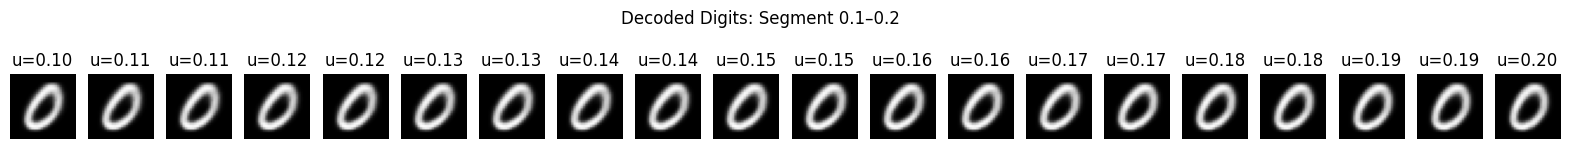

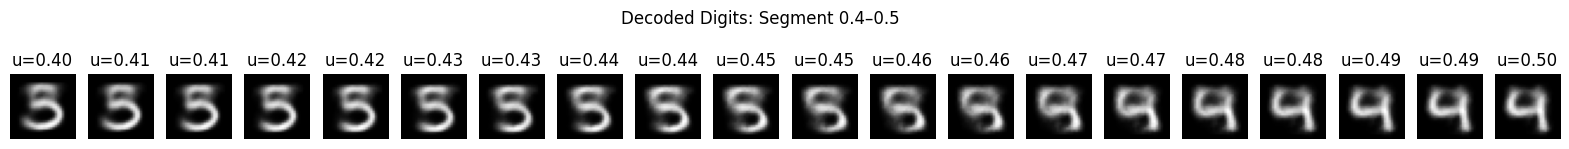

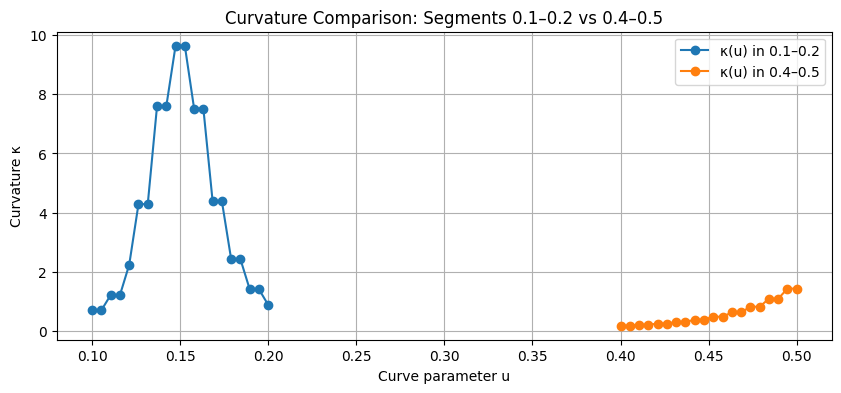

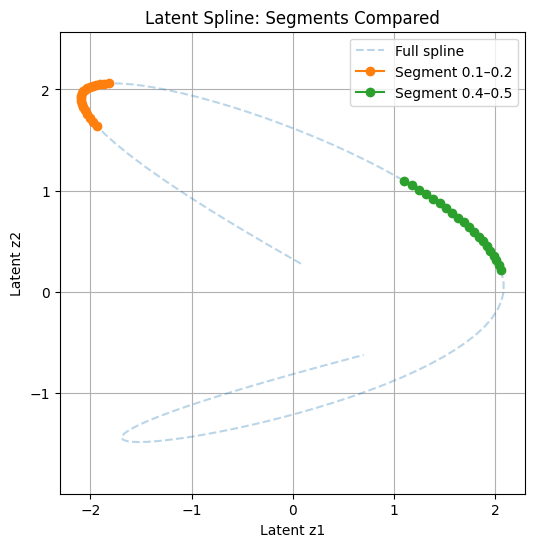

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import splev

# Define segment ranges
segments = {
    "0.1–0.2": np.linspace(0.1, 0.2, 20),
    "0.4–0.5": np.linspace(0.4, 0.5, 20)
}

model.eval()
segment_data = {}

with torch.no_grad():
    for name, u_vals in segments.items():
        decoded_imgs = []
        curvatures = []
        coords = []

        for u in u_vals:
            z = np.array(splev(u, tck))
            coords.append(z)

            # Decode image
            z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)
            decoded = model.decode(z_tensor).cpu().squeeze().numpy()
            decoded_imgs.append(decoded)

            # Curvature
            idx = np.argmin(np.abs(u_fine - u))
            curvatures.append(curvature[idx])

        segment_data[name] = {
            "u_vals": u_vals,
            "decoded_imgs": decoded_imgs,
            "curvatures": np.array(curvatures),
            "coords": np.array(coords)
        }

# -------------------------------
# Plot decoded digits for both segments
for name in segments:
    imgs = segment_data[name]['decoded_imgs']
    u_vals = segment_data[name]['u_vals']
    plt.figure(figsize=(20, 2))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"u={u_vals[i]:.2f}")
        plt.axis('off')
    plt.suptitle(f"Decoded Digits: Segment {name}")
    plt.show()

# -------------------------------
# Plot curvature comparison
plt.figure(figsize=(10, 4))
for name in segments:
    u_vals = segment_data[name]['u_vals']
    k_vals = segment_data[name]['curvatures']
    plt.plot(u_vals, k_vals, marker='o', label=f"κ(u) in {name}")
plt.title("Curvature Comparison: Segments 0.1–0.2 vs 0.4–0.5")
plt.xlabel("Curve parameter u")
plt.ylabel("Curvature κ")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# Plot both segments in latent space
plt.figure(figsize=(6, 6))
plt.plot(x_spline, y_spline, linestyle='--', alpha=0.3, label="Full spline")
for name in segments:
    coords = segment_data[name]['coords']
    plt.plot(coords[:, 0], coords[:, 1], marker='o', label=f"Segment {name}")
plt.title("Latent Spline: Segments Compared")
plt.xlabel("Latent z1")
plt.ylabel("Latent z2")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


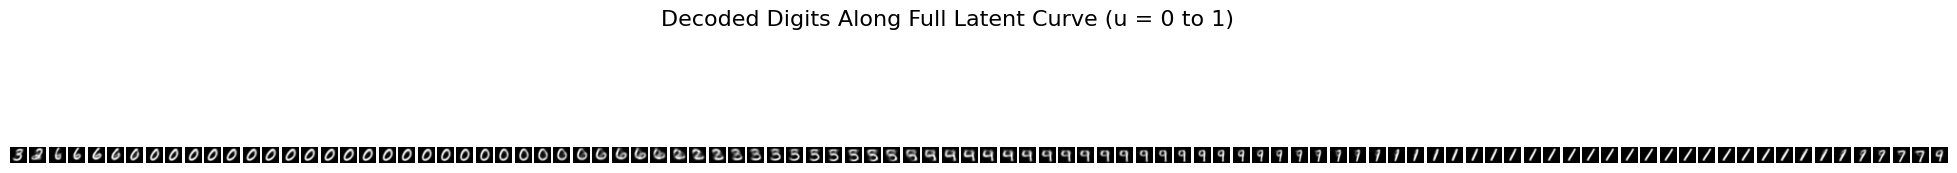

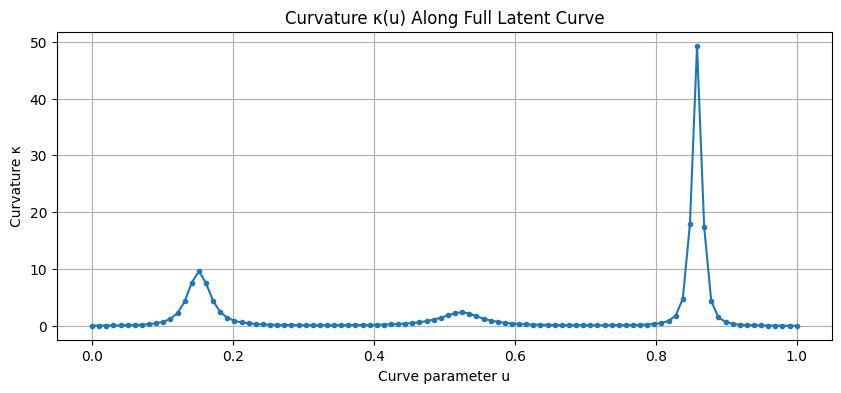

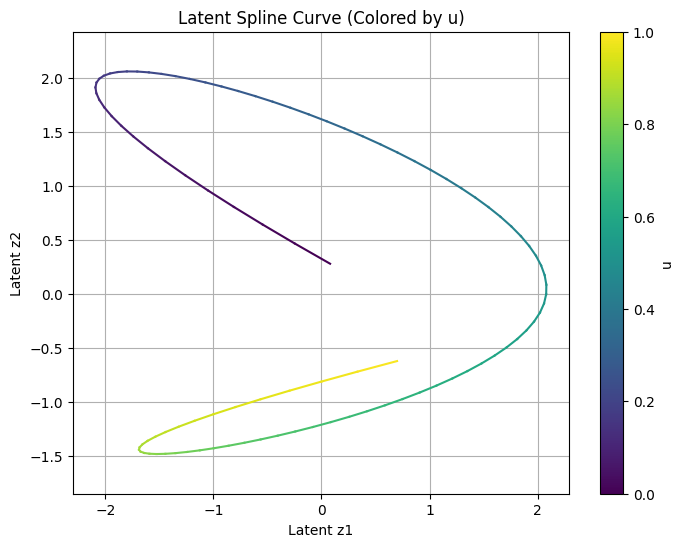

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import splev
import matplotlib.cm as cm

# 1. Sample all u-values along spline
u_all = np.linspace(0, 1, 100)
decoded_imgs = []
curvatures_all = []
coords_all = []

model.eval()
with torch.no_grad():
    for u in u_all:
        z = np.array(splev(u, tck))
        coords_all.append(z)

        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)
        decoded = model.decode(z_tensor).cpu().squeeze().numpy()
        decoded_imgs.append(decoded)

        idx = np.argmin(np.abs(u_fine - u))
        curvatures_all.append(curvature[idx])

coords_all = np.array(coords_all)
curvatures_all = np.array(curvatures_all)

# --------------------------
# 1. Plot decoded digits
plt.figure(figsize=(25, 3))
for i, img in enumerate(decoded_imgs):
    plt.subplot(1, len(decoded_imgs), i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle("Decoded Digits Along Full Latent Curve (u = 0 to 1)", fontsize=16)
plt.show()

# --------------------------
# 2. Curvature plot
plt.figure(figsize=(10, 4))
plt.plot(u_all, curvatures_all, marker='o', markersize=3)
plt.title("Curvature κ(u) Along Full Latent Curve")
plt.xlabel("Curve parameter u")
plt.ylabel("Curvature κ")
plt.grid(True)
plt.show()

# --------------------------
# 3. Latent space trajectory with u-colored path
fig, ax = plt.subplots(figsize=(8, 6)) # Create figure and axes
colors = cm.viridis(u_all)
for i in range(len(coords_all)-1):
    x0, y0 = coords_all[i]
    x1, y1 = coords_all[i+1]
    ax.plot([x0, x1], [y0, y1], color=colors[i])

ax.set_title("Latent Spline Curve (Colored by u)")
ax.set_xlabel("Latent z1")
ax.set_ylabel("Latent z2")
ax.axis('equal')
ax.grid(True)
plt.colorbar(cm.ScalarMappable(cmap='viridis'), ax=ax, label="u") # Pass the axes to colorbar
plt.show()

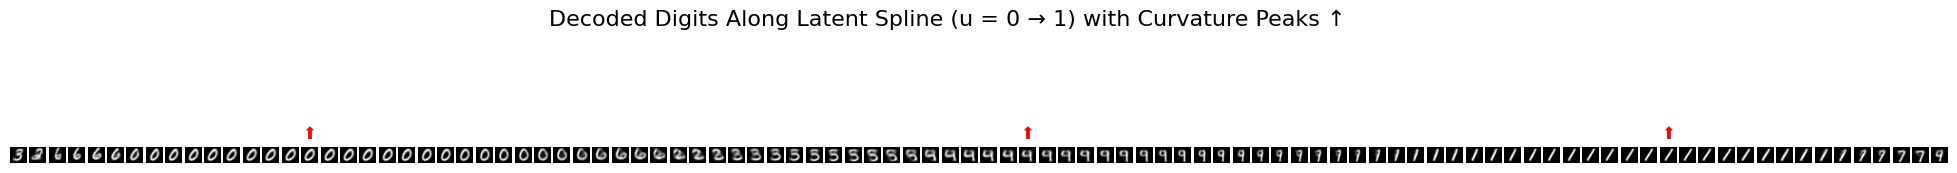

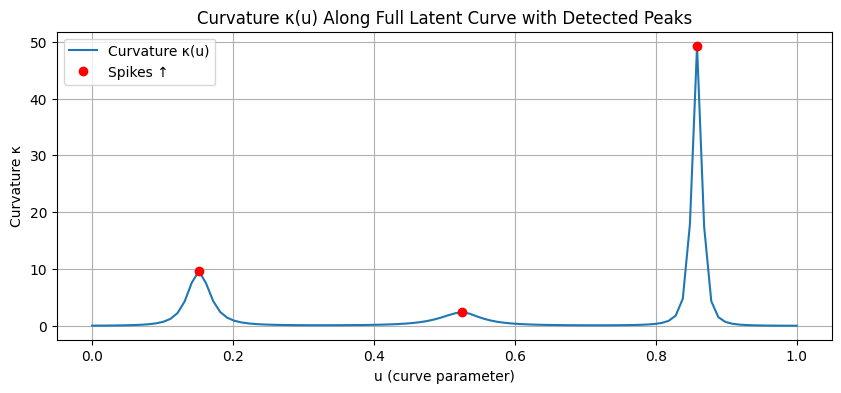

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Identify local maxima in curvature
# Adjust 'prominence' to control sensitivity
peaks, _ = find_peaks(curvatures_all, prominence=0.1)

# --- Plot decoded digits with spike markers
plt.figure(figsize=(25, 3))
for i, img in enumerate(decoded_imgs):
    plt.subplot(1, len(decoded_imgs), i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i in peaks:
        plt.title(f"⬆", color='red', fontsize=12)
plt.suptitle("Decoded Digits Along Latent Spline (u = 0 → 1) with Curvature Peaks ↑", fontsize=16)
plt.show()

# --- Plot curvature and mark peaks
plt.figure(figsize=(10, 4))
plt.plot(u_all, curvatures_all, label="Curvature κ(u)")
plt.plot(u_all[peaks], np.array(curvatures_all)[peaks], "ro", label="Spikes ↑")
plt.title("Curvature κ(u) Along Full Latent Curve with Detected Peaks")
plt.xlabel("u (curve parameter)")
plt.ylabel("Curvature κ")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Replace these with your actual data arrays:
# mu_points = np.array([...])  # shape (N, latent_dim)
# u_all = np.linspace(0, 1, len(mu_points))

# Example dummy data (remove this when you have your real data)
if 'mu_points' not in globals():
    N = 100
    u_all = np.linspace(0, 1, N)
    mu_points = np.stack([np.sin(2 * np.pi * u_all), np.cos(2 * np.pi * u_all)], axis=1)

# Compute gradient of mu w.r.t u
dmu_du = np.gradient(mu_points, u_all, axis=0)

# Compute norm of gradient vectors
grad_norm = np.linalg.norm(dmu_du, axis=1)

# Plot gradient norm
plt.figure(figsize=(10, 4))
plt.plot(u_all, grad_norm, label='Gradient norm of latent means ||dμ/du||')
plt.xlabel('Spline parameter u')
plt.ylabel('Gradient norm')
plt.title('Gradient Norm of Latent Means Along Spline')
plt.grid(True)

# Find peaks as candidate transition points
peaks, _ = find_peaks(grad_norm, prominence=0.1)
plt.plot(u_all[peaks], grad_norm[peaks], 'ro', label='Detected Peaks')

plt.legend()
plt.show()

print("Detected transition points at u values:")
print(u_all[peaks])


ValueError: when 1d, distances must match the length of the corresponding dimension

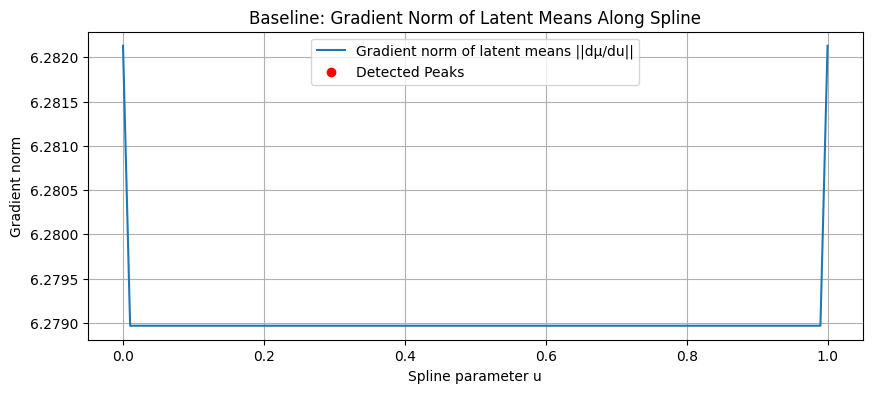

Detected transition points at u-values:
[]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# === INPUT: replace these with your actual arrays ===
# mu_points = np.array([...])  # shape (N, latent_dim), e.g. (100, 2)
# u_all = np.linspace(0, 1, len(mu_points))  # or your actual parameter values

# For demonstration, here's dummy data to run this block standalone
# Remove or replace this before running with your actual data
if 'mu_points' not in globals():
    N = 100
    u_all = np.linspace(0, 1, N)
    # Simulate a 2D latent mean path with some curvature
    mu_points = np.stack([np.sin(2 * np.pi * u_all), np.cos(2 * np.pi * u_all)], axis=1)

# 1. Compute discrete gradient w.r.t u
dmu_du = np.gradient(mu_points, u_all, axis=0)  # shape (N, latent_dim)

# 2. Compute gradient norm at each point
grad_norm = np.linalg.norm(dmu_du, axis=1)  # shape (N,)

# 3. Plot gradient norm vs u
plt.figure(figsize=(10,4))
plt.plot(u_all, grad_norm, label="Gradient norm of latent means ||dμ/du||")
plt.title("Baseline: Gradient Norm of Latent Means Along Spline")
plt.xlabel("Spline parameter u")
plt.ylabel("Gradient norm")
plt.grid(True)

# 4. Detect peaks (candidate transitions)
peaks, _ = find_peaks(grad_norm, prominence=0.1)
plt.plot(u_all[peaks], grad_norm[peaks], "ro", label="Detected Peaks")
plt.legend()
plt.show()

print(f"Detected transition points at u-values:\n{u_all[peaks]}")


In [ ]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# ==== INPUT ====
# z: numpy array of shape (N, latent_dim) containing your latent spline points
# If you don't have z yet, define it or generate spline latent points first
# Example dummy data if you want to test the code, remove if you have real z
if 'z' not in globals():
    N = 100
    t_vals = np.linspace(0, 1, N)
    z = np.stack([np.cos(2 * np.pi * t_vals), np.sin(2 * np.pi * t_vals)], axis=1)  # Example 2D circle spline

mu_points = []

with torch.no_grad():
    for zi in z:
        # Convert latent vector to tensor, add batch dim, and send to device
        z_tensor = torch.tensor(zi, dtype=torch.float32).unsqueeze(0).to(device)  # shape (1, latent_dim)

        # Decode latent to image
        decoded_img = model.decode(z_tensor)  # shape: (1, channels, height, width) expected

        # Encode image back to get mu and logvar
        mu, logvar = model.encode(decoded_img)  # expected output shapes (1, latent_dim)

        # Append mu vector (remove batch dim, move to cpu, numpy)
        mu_points.append(mu.cpu().numpy().squeeze())

mu_points = np.array(mu_points)  # shape (N, latent_dim)

print(f"Extracted mu_points shape: {mu_points.shape}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1 and 2x256)

In [ ]:
!git clone https://github.com/intuition-explorer/LatentCurveMNIST

Cloning into 'LatentCurveMNIST'...
